# A Python powered Framework for Network Performance Data Analysis-Part 1

Erdem Koç

Standard network optimization tasks include, in most general way, an infinite
loop of changes and analysis tasks. Changes in network consists of but is not
limited to several parameter changes. A huge amount of know-how is required
in changes part and this branch itself is a separate professional field.

![loop](img\loop.jpg)

Assuming the technical reasoning and the purpose of a change is known, next
step is always monitoring/analyzing related KPIs.

***And this is what this notebook is all about...***

***What this document includes is *** definitions, best practices, tips for
a Python powered framework for Network Data Analysis that increases
the detail level of and speeds up the above mentioned loop.

***What this document does not include*** is any specific mobile network
technology, vendor specific KPI definition and/or counter name.

***Potential target audience*** includes (but is not limited to) any network
engineer/data analyst or similar technical personnel who is interested in
 flexible, resizable and custom methods of analysis and monitoring of
network performance indicators.

***Prerequisites*** to follow this document are
* knowledge about basic counter concept in mobile network performance analyis 
* familiarity of python, especially pandas, matplotlib and numpy 
* familiarity of general relational databases and SQL 

It is possible to separate the task of analysis into following major parts.

<ol>
<li><a href="#source">Source</a></li>
<li><a href="#access">DB Access</a>
    <ol>
        <li><a href="#oracle">Using Python With Oracle Database</a></li>
        <li><a href="#helper">A Simple Helper Class for DB Connection </a></li>
    </ol>
    </li>
<li><a href="#visualization">Visualization Methods</a>
        <ol>
        <li><a href="#networkcon">networkcon class</a></li>
        <li><a href="#1dplots">Simple one-liner plots and method overloading</a></li>
        <li><a href="#2dplots">Multi-index Data and Unstacking over a Category</a></li>
        <li><a href="#pdf">Plotting PDF Counters</a></li>
        <li><a href="#variable"> Plotting variable number of Counters</a></li>
        </ol>
    </li>
    </li>
</ol>


<a id='source'></a>
## 1. Source

> Before going into technical detail, I would like to emphasize that this part
assumes the reader has already a moderate and/or better knowledge of the concept
of ***counter*** for mobile networks.

What separates network performance data that consist of network component
counters from any other generic source of data is the fact that network
counters already define a very specific type of source structure.

In most basic way, counter is an incremental data value that increments (and may
reset) in case of a specific occurrence that is detected by a network component.

This gives us an advantage especially while writing queries. Every, if not all,
counter is to be aggregated over a dimension of interest. The traditional design
of tables and incremental origin of creating data makes this aggregation nothing
but a simple ```SUM```.

> It must be noted here that, there are different types of incremental counters
like ***ACC, PEG, GAUGE and PDF***. The 1st 3 are similar and will be handled different
only when it is necessary. I will mention PDFs below in a bit more detail, as
bin structure need special attention.

Dimension of interest over which aggregation is to be done can be, minute,
hour, day, a geographic region etc. ***These dimensions are very critical while
defining a framework that will work on each and every possible counter, in
each and every possible level of aggregation.***

An experienced data analyst may already have figured out that, aggregation only
via SUM may have serious disadvantages while comparing and/or numerically
evaluating data after aggregation and he/she is right. The fact is, although in
daily life it may be enough to look at accumulated values of counters to
understand if something is wrong, ***if we want to compare we need to
normalize the data.*** This is again possible thanks to the traditional design
of counter based data storage. To be more clear, as I tried to stress up to here,
we are dealing with a very well defined source. We will come to this normalization
process in more detail in later.

For now, let's continue with the 3rd possible aggregation method, which is nothing
but an extension of incremental counters, namely PDFs.

 Putting mathematical details aside, PDFs are group of ***dependent*** counters,
 each of which correspond to a bin, that spans the possible range of that counters
 or interest. Although it is called PDF the sum of all bins will not be equal to
 one. This may or may not be important depending on what we need to look at.

 The hardest thing about PDF counters is that, every bin corresponds to an interval
 of usually numerical value, but the names will not be referring to these ranges
 most of the time. This challenge will be more clear once we try to plot them.

Because of all the rule of thumbs mentioned below, we will be able to write ***almost***
all of our queries according to the pseudo-query below:

```sql
SELECT  CATEGORY,
        DATETIME,
        SUM(COUNTER1) AS COUNTER1,
        PERCENT(SUM(COUNTER2),SUM(COUNTER3)) AS PERCENTAGE
        SUM(PDF_COUNTER_1) AS COUNTER_BIN_1,
        SUM(PDF_COUNTER_2) AS COUNTER_BIN_2,
        ...
        SUM(PDF_COUNTERN) AS COUNTER_BIN_N

FROM COUNTER_TABLE
```
That is, we may have
*  categories
*  date-time columns
*  normalized values
*  pdf counter(s) bins of which will be separate column but must be handled as a unit

Note that actual queries will be much more complex than the pseudo-query above,
probably joining several tables. But it will always be possible to keep the same logic no matter how many counters
we have. This generic structure will be our basis on writing a Python library to be
able to fetch data always in well-defined format.

A general rule of thumb would be:

>*** Do anything which cannot be done using
the above structure, in Python.***

<a id='access'></a>
## 2. DB Access


<a id='oracle'></a>
### 2.A. Using Python With Oracle Database

It is highly probable that the counters will be kept in an Oracle environment. And
from here starts the Pythons magic. I will not go details of how to connect a
Oracle database, because it is already done with perfect detail
[here](http://www.oracle.com/technetwork/articles/dsl/python-091105.html)
and you may also want to look
[here](http://cx-oracle.readthedocs.io/en/latest/installation.html).

<a id='helper'></a>
### 2.B. A Simple Helper Class for DB Connection

It is a well known fact that Python is not usually about classes and all, but once
it comes to keeping things clean, I could not think of a better solution than
writing a connection class that will take into account all the structure I described
above and use SQL queries under the hood.

> Here I assume that the reader already is familiar ***pandas*** and major
concepts of object oriented programming.

So we create a class as follows, which will make our life easier in Python:

* dataframe with datetime index
* dataframe with object index
* dataframe with datetime, object multi-index

![dataframe](img\dataframe.jpg)

>Note that multi-index from 2 object type and or datetime type (also interger etc.) is also possible as long as proper methods are implemented. Unstacking method will behave same, datetime object is just a special case of x-axis as timeline. To keep the class implementation simple, I will only use
the combinations above

Now, having defined the structure above, we can write a class that will have methods capable of 
providing data from a network counter database that will strictly obey the datadrame structure above. 

![conclass](img\connclass.jpg)

```python

import os
import sqlite3 #import cx_Oracle
import pandas as pd
from . import log

class networkcon(object):
    """
    List of functions to call queries of specific type from relative path
    'query_path'. Note that most of the queries to be used by functions below
    must have specific type of input paramteres and output columns.

    i.e.
    it must be made sure that a query returns at least the row that is expected
    in index column
    """

    con = None

    # queries_folder is the name of the folder wrt this class where we keep queries
    # that are to be executed by functions of this class
    queries_folder = 'queries'

    def __init__(self, dbname): # def __init__(self, conn_string):
        """Oracle or similar dbs may need connection string"""

        self.dbname = dbname # self.conn_string = conn_string
        self.query_path = os.path.join(os.path.dirname(__file__)
            , self.queries_folder)

    def connect(self):
        self.con = sqlite3.connect(self.dbname, detect_types=sqlite3.PARSE_DECLTYPES)
        # self.con = cx_Oracle.connect(self.conn_string, encoding='UTF-16', nencoding='UTF-16')
        log.log_to_scr(__file__, "conected to db...")
        log.log_to_scr(__file__, "fetching queries from " + self.query_path )

    def disconnect(self):
        if self.con:
            self.con.close()
            log.log_to_scr(__file__, str(self.dbname)+" is closed.")
        else:
            log.log_to_scr(__file__, "nothing to close")

    def read_query(self, full_query_path):
        """simply read queries"""
        log.log_to_scr("networkcon", "running " + str(full_query_path))
        with open(full_query_path, "r") as query:
            return query.read()

    def get_simple(self, query):
        """returns a dataframe in its most basic form"""
        return pd.read(self.read_query(self.query_path + "\\" + query)
            , con=self.con)

    def get_custom(self, query, params, index_col):
        """returns a dataframe with optional parameters for query and index
        columns. This is the most generic way of running a query and get result
        in a dataframe"""
        return pd.read_sql( self.read_query(self.query_path + "\\" + query)
                            , con=self.con
                            , params=params
                            , index_col=index_col)

    def get_dtime(self, param1, param2  , query="query_dtim.sql"
                                                    , index_col='DATETIME'):
        return pd.read_sql( self.read_query(self.query_path + "\\" + query),
                            con=self.con,
                            params={'FILTER_1':param1, 'FILTER_2':param2},
                            index_col=index_col)

    def get_cat(self, param, query="query_cat.sql", index_col='CATEGORY_1'):
        return pd.read_sql( self.read_query(self.query_path + "\\" + query),
                            con=self.con,
                            params={'FILTER':param},
                            index_col=index_col)

    def get_dtim_cat(self, param1, param2, query="query_dtim_cat.sql"
                                    , index_col=['DATETIME','CATEGORY_1']):
        return pd.read_sql( self.read_query(self.query_path + "\\" + query),
                                con=self.con,
                                params={'FILTER_1':param1, 'FILTER_2':param2},
                                index_col=index_col)

```

<a id='visualisation'></a>
## 3. Visualisation Methods

Following is an explanatory demonstration of concepts mentioned above. 

<a id='networkcon'></a>
### 3.A. networkcon class

We start by importing our helper class and usual pandas and matplotlib libraries.

In [1]:
from networklib import networkcon 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's instantiate a ***networkcon*** object that will make it easier to connect, disconnect to our database and to run queries under the hood. 

In [2]:
nw = networkcon.networkcon("database/network.db")
nw.connect()

2018-07-02 14:27:08.520456 - C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\networkcon.py - conected to db...
2018-07-02 14:27:08.521457 - C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\networkcon.py - fetching queries from C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries


<a id='1dplots'></a>
### 3.B. Simple one-liner plots and method overloading
After nw object is connected we can use it to run either predefined methods or custom queries. 

Let's aggegate over a category with some filter over a counter

In [3]:
nw.get_cat(3)

2018-07-02 14:27:17.110216 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_cat.sql


,SUM_COUNTER_1,PERCENTAGE
CATEGORY_1,,
A,204.3820,0.998965
B,208.3688,0.998398
C,177.1129,0.999090
D,171.8613,0.999400


get_cat() method has a default query to run. 


```python
    def get_cat(self, param, query="query_cat.sql", index_col='CATEGORY_1'):
    ...
```
We can overload it by a different query if we are sure that it returns a dataframe of similar structure. Here "query_cat2.sql" must return an index as "CATEGORY_1" or of course we can overload it with another index column name. 

In [4]:
nw.get_cat(3, query="query_cat2.sql", index_col="CATEGORY_1")

2018-07-02 14:27:26.902775 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_cat2.sql


,SUM_COUNTER_1,SUM_COUNTER_2,PERCENTAGE
CATEGORY_1,,,
A,204.3820,8162979137,0.998965
B,208.3688,13076532225,0.998398
C,177.1129,5898861779,0.999090
D,171.8613,7457922487,0.999400


This simple structure makes a one-liner plot possible. 

2018-07-02 14:27:31.078567 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_cat2.sql


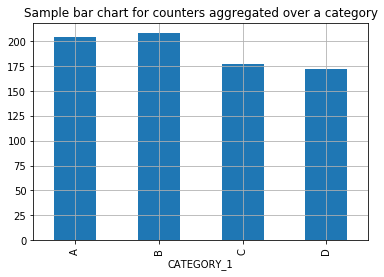

In [5]:
nw.get_cat(3, query="query_cat2.sql").SUM_COUNTER_1.plot(kind="bar"
                                                         , grid=True
                           , title="Sample bar chart for counters aggregated over a category")

get_dtime() function is exactly the same, the only difference being the index column type ***datetime***.

> Datetime indexes are very useful especially while plotting. Most of the time ***matplotlib*** takes care of all cosmetic issues that arise once we swith between hours, dates, minutes etc. 

Let's plot a trend chart of a percentage KPI we calculated with a one-liner. A simple co-operation between our "nw" object and matplotlib. Nice and easy ;) 

2018-07-02 14:27:36.165680 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_dtim.sql


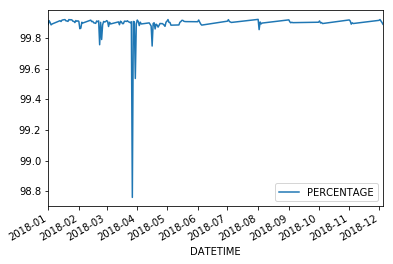

In [6]:
nw.get_dtime(param1=0, param2=3).plot()

<a id='2dplots'></a>
### 3.C. Multi-index Data and Unstacking over a Category

Up to here we plotted only one dimensional data or a better naming would be single series in chart nomenclature. In real life most of the time it will be necessary to compare KPIs of different categories like, regions, cities, vendors etc. 

> Below example uses a multi-index of one string and one datetime index as multi-index. Extension to 
string-string, datetime-datetime etc. is the same.

In [7]:
nw.get_dtim_cat(param1=0,param2=3).head(10)

2018-07-02 14:27:38.906036 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_dtim_cat.sql


PERCENTAGE
DATETIME   CATEGORY_1            
2018-01-01 A            99.861563
           B            99.857438
           C            99.921194
           D            99.948912
2018-01-02 A            99.915452
           B            99.890788
           C            99.912085
           D            99.946661
2018-01-03 A            99.902305
           B            99.872498

And some more one-liner plots directly from a database thanks to pandas 

2018-07-02 14:27:41.350554 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_dtim_cat.sql


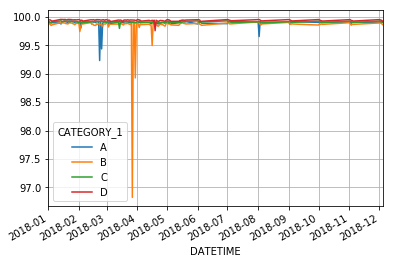

In [8]:
nw.get_dtim_cat(0,3).unstack("CATEGORY_1").PERCENTAGE.plot(grid=True)

2018-07-02 14:27:43.318164 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_dtim_cat.sql


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000003DCC9A56A0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000003DCDCC7748>]], dtype=object)

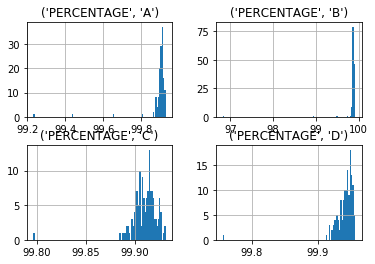

In [9]:
nw.get_dtim_cat(0,3).unstack("CATEGORY_1").hist(bins=100)

<a id='pdf'></a>
### 3.D. Plotting PDF Counters

Up to here I wanted to keep it as simple as possbile, and I will try to avoid any unnecessary imports as possible. 

Nevertheless, once we start to think about PDF counters using multiple related columns, matplotlib alone has some drawbacks. 

***At this point [seaborn](http://seaborn.pydata.org/index.html) turns out to be extremely useful and fits with our predefined dataframe structure. Let's import it and plot some PDF counters***  

In [10]:
import seaborn as sns

Although in real life you will probably have multiple PDF counters, whether to fetch them via differnet queries or use a bigger query and later slice the dataframe accourdingly is a desgin issue. 

I personally prefer to minimize the number of different queries to use, which leads to relatively big dataframes in terms of number of columns and then slice them using pandas. 

However, here I prefer not to go into pandas very much and use simple dataframes, because this document is about the final dataframe format arising from network counters. 

So, lets use our get_dtime() function, overloading it with a query which we know fetches columns of a PDF counter. Namely COUNTER_1_BIN, COUNTER_2_BIN, ....COUNTER_24_BIN.

Here note how we aggregate over CATEGORY implicitly by only grouping by DATETIME. This query structure is very important when generating an interface that will work with any counter and any number of categories. 

```sql
SELECT
DATETIME,
SUM(COUNTER_1_BIN) BIN_1,
SUM(COUNTER_2_BIN) BIN_2,
...
SUM(COUNTER_14_BIN) BIN_14

FROM counter_table

WHERE DATETIME > :FILTER_1 and DATETIME < :FILTER_2
GROUP BY DATETIME
GROUP BY DATETIME
```

> ***Note:***  in Oracle you would need to convert FILTER_i to datetime but sqlite is more forgiving in this example.

In [11]:
nw.get_dtime('2018-11-01 00:00:00', '2018-12-01 00:00:00', query="query_dtim_PDF.sql").head()

2018-07-02 14:28:11.058112 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_dtim_PDF.sql


,BIN_1,BIN_2,BIN_3,BIN_4,BIN_5,BIN_6,BIN_7,BIN_8,BIN_9,BIN_10,BIN_11,BIN_12,BIN_13,BIN_14
DATETIME,,,,,,,,,,,,,,
2018-11-02,1.2212,1.5602,2.7508,6.2572,12.5664,21.6398,28.3640,38.6049,44.4309,39.4607,45.3551,45.2151,30.4632,27.7333
2018-11-03,1.2973,1.6960,3.0305,6.9418,13.6984,22.9668,29.6155,39.5817,44.8586,39.3401,44.5767,44.2597,29.4191,26.7184
2018-11-04,1.3339,1.5658,2.5729,5.6798,11.8245,20.9493,27.9589,38.3960,44.3081,39.7510,45.4724,45.3177,30.6566,28.7990
2018-11-05,1.2405,1.4836,2.5128,5.5876,11.6370,20.8317,27.7975,38.4541,44.7036,40.0806,45.7171,45.6160,30.8924,28.8789


and some seaborn magic

2018-07-02 14:28:13.446525 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_dtim_PDF.sql


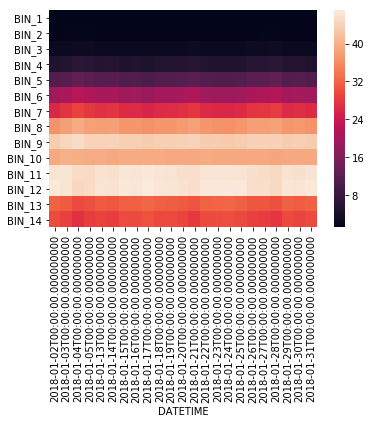

In [12]:
sns.heatmap(nw.get_dtime('2018-01-01 00:00:00'
                         ,'2018-02-01 00:00:00', query="query_dtim_PDF.sql").transpose()
            ,annot=False)

Note that we are working with counters. This means ***we cannot guarantee that the total number of samples are going to be equal in each consecutive day.***  i.e. it may be possible that consideranbly less samples are counted for example due a to an outage for a specigic day. 


The plot above considers all the samples regardless of the day while applying the colormap. So, changes in accumulated values will be reflected to colormap, but for a PDF counter ***distribution*** is more interesting. So, we can either plot heatmap for each day (or any other groping we need for that matter.) or ***normalize the daily distributions.***


By the time i am writing this document I made a quick search but could not find an already implemented density option for such a task. So let's do it ourselves.  

In [13]:
a = nw.get_dtime('2018-01-01 00:00:00', '2018-02-01 00:00:00', query="query_dtim_PDF.sql")
a.head()

2018-07-02 14:28:15.867439 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_dtim_PDF.sql


,BIN_1,BIN_2,BIN_3,BIN_4,BIN_5,BIN_6,BIN_7,BIN_8,BIN_9,BIN_10,BIN_11,BIN_12,BIN_13,BIN_14
DATETIME,,,,,,,,,,,,,,
2018-01-02,1.2441,1.4441,2.3692,5.2029,10.8144,19.4554,26.2021,36.8370,43.2765,39.2345,46.1698,46.6596,31.8450,29.9905
2018-01-03,1.2739,1.5237,2.5053,5.4858,11.4113,20.3898,27.4278,38.1068,44.4214,40.0457,46.2910,46.2647,31.2941,28.8495
2018-01-04,1.2961,1.5897,2.7452,6.2229,12.6521,22.0283,29.1295,39.4892,45.1238,39.7824,45.1239,44.6968,29.7608,27.2583
2018-01-05,1.3220,1.5906,2.7213,6.0547,12.2778,21.2294,27.9137,38.1440,44.1328,39.4681,45.0354,45.0458,30.3847,28.5410
2018-01-13,1.1732,1.4371,2.4348,5.5399,11.4177,20.3147,27.3183,38.0090,44.2084,39.5689,46.0092,46.0990,31.2259,28.9933


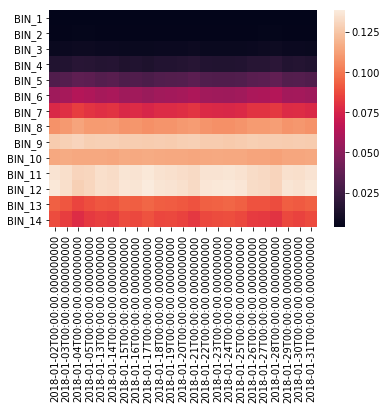

In [14]:
b=pd.DataFrame()

for index, row in a.iterrows():
    #normalise each row
    b[index]= row/row.sum()

sns.heatmap(b, annot=False)

<a id='variable'></a>
### 3.4. Plotting variable number of Counters

Up to now, we only plotted one counter or CDF counters which are related into one chart. In real life almost always, it will be necessary to plot several counters at once. 

If the number of counters is less than 10 or so, standard [subplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) methods are straightforward. Since this document is not a 1000th tutorial of how to use subplot in matplotlib, I leave it to the reader.

***But... A challange would be the case that you want to check 50 or more counters at once.*** Below is a function that filters numerical columns and treats each column as a seperate counter and plots them into a NxM matrix layout.

> Note that in practical cases where we want to analyse > 50 charts it is best practice to switch of matplotlib and save figure into a pdf or any other preferred format. Here number of columns we will get from our databse is relatively low, and we can plot it onto screen. 
Note als that we treat PDF counters as if they are independent counters for sake of demonstration.


In [15]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

def plt_all_dtime(df, pdate   , unstack_col="CATEGORY_1"
                              , fig_x_inches=20
                              , fig_y_inches=30
                              , label_font_size=12
                              , title_font_size=12
                              , nr_columns=4
                              , styles=None
                              , y_axis_limit_factor=0.1):

    '''
    given a dataframe df with a minimum 1 numerical column and a
    multtinedex of size 2, this function plots one index in x axis and
    unstacks the other one.
    
    pdate: datetime to plot a vertical line on x axis if desired
    
    y_axis_limit_factor: (0,1) avoids y axis to be set to a max 
    value in trends for better visualisation
    
    nr_columns: this determines how many graphs in parallel will be 
    plotted in one row. number of rows depend on this and total columns
    to be plotted
    
    '''

    try:
        pdate_dt = dt.datetime.strptime(pdate, "%d-%m-%Y")
    except ValueError:
        pdate_dt = False
        print(" warning: could not parse " + pdate + " as datetime...")

    # get numerical columns and remove possible duplicates
    nf = df.select_dtypes(include=[np.number])
    nf = nf.loc[:,~nf.columns.duplicated()]

    # initialize before loop
    i = 0
    pos = range(2, nf.shape[1]+3)

    fig = plt.figure()

    # column is just string column names (not array, list or sth similar)
    for column in nf:
        # +1 is because we shift at start to make place for legend and this may
        # cause an extra column
        ax = fig.add_subplot(ceil(nf.shape[1]/nr_columns)+1, nr_columns, pos[i])
        ax.tick_params(axis="both", labelsize=label_font_size)
        ax.set_title(str(column), fontsize=title_font_size)
        ax.axes.get_xaxis().get_label().set_visible(False)

        if pdate_dt:
            ax.axvline(pdate_dt, linewidth=3, color='k', linestyle=':')

        # scale limits of y avis for better view
        # Nans are possible so we try
        try:
            if min(nf[column]) != max(nf[column]):
                plt.ylim(min(nf[column])*(1-y_axis_limit_factor)
                        ,max(nf[column])*(1+y_axis_limit_factor))
        except ValueError:
            pass

        # note 1 is empty for legend space and it starts from 2
        if pos[i] == 2:
            if styles is None:
                nf[column].unstack(unstack_col).plot(ax=ax)
            else:
                nf[column].unstack(unstack_col).plot(ax=ax, style=styles)

            ax.legend(bbox_to_anchor=(-0.7, 0.5), loc="center"
                , fontsize=title_font_size, ncol=3)
        else: # rest does not have legend
            if styles is None:
                nf[column].unstack(unstack_col).plot(ax=ax, legend=False)
            else:
                nf[column].unstack(unstack_col).plot(ax=ax, legend=False, style=styles)

        i+=1
        
    fig.set_size_inches(fig_x_inches, fig_y_inches)
    plt.tight_layout()

In [16]:
b = nw.get_dtim_cat(0,3,query="query_dtim_cat2.sql")
b.head()

2018-07-02 14:29:17.396631 - networkcon - running C:\Users\tcerdkoc\AppData\Local\Continuum\anaconda3\networklib\queries\query_dtim_cat2.sql


CATEGORY_2  COUNTER_1  COUNTER_2  COUNTER_3  \
DATETIME   CATEGORY_1                                               
2018-01-01 A                CITY     2.1081   56614730   56536354   
           B                CITY     1.9915   75222071   75114833   
           C              COUNTY     1.2802   29515491   29492231   
           D              COUNTY     1.1836   45953960   45930483   
2018-01-02 A                CITY     1.4316   57560043   57511377   

                       COUNTER_1_BIN  COUNTER_2_BIN  COUNTER_3_BIN  \
DATETIME   CATEGORY_1                                                
2018-01-01 A                  0.2562         0.3804         0.7494   
           B                  0.3028         0.4896         1.0243   
           C                  0.2792         0.2619         0.3635   
           D                  0.3134         0.4522         0.8595   
2018-01-02 A                  0.2784         0.3241         0.5221   

                       COUNTER_4_BIN  COUNTER_5_BIN  COUNTER_6_BIN  \
DATETIME   CATEGORY_1                                                
2018-01-01 A                  1.9666         4.0884         6.9107   
           B                  2.5180         4.6992         7.2737   
           C                  0.7455         1.6659         3.4236   
           D                  2.0406         3.9261         6.3128   
2018-01-02 A                  1.2015         2.7053         5.1010   

                       COUNTER_7_BIN  COUNTER_8_BIN  COUNTER_9_BIN  \
DATETIME   CATEGORY_1                                                
2018-01-01 A                  8.9036        11.4679        12.2877   
           B                  9.1088        11.3955        11.9904   
           C                  5.0247         7.8422        10.0256   
           D                  8.1736        10.6351        11.6110   
2018-01-02 A                  7.0307         9.9341        11.5694   

                       COUNTER_10_BIN  COUNTER_11_BIN  COUNTER_12_BIN  \
DATETIME   CATEGORY_1                                                   
2018-01-01 A                  10.1451         10.9939         10.1746   
           B                   9.7863         10.4912          9.7576   
           C                   9.6774         11.8198         12.4929   
           D                   9.8389         10.9120         10.4569   
2018-01-02 A                  10.3053         11.9214         11.6910   

                       COUNTER_13_BIN  COUNTER_14_BIN  
DATETIME   CATEGORY_1                                  
2018-01-01 A                   6.4098          5.5859  
           B                   6.1860          5.3808  
           C                   8.8653          8.5460  
           D                   6.8157          6.1777  
2018-01-02 A                   7.7411          7.0728

Let's plot every numerical column and format the lines as we please

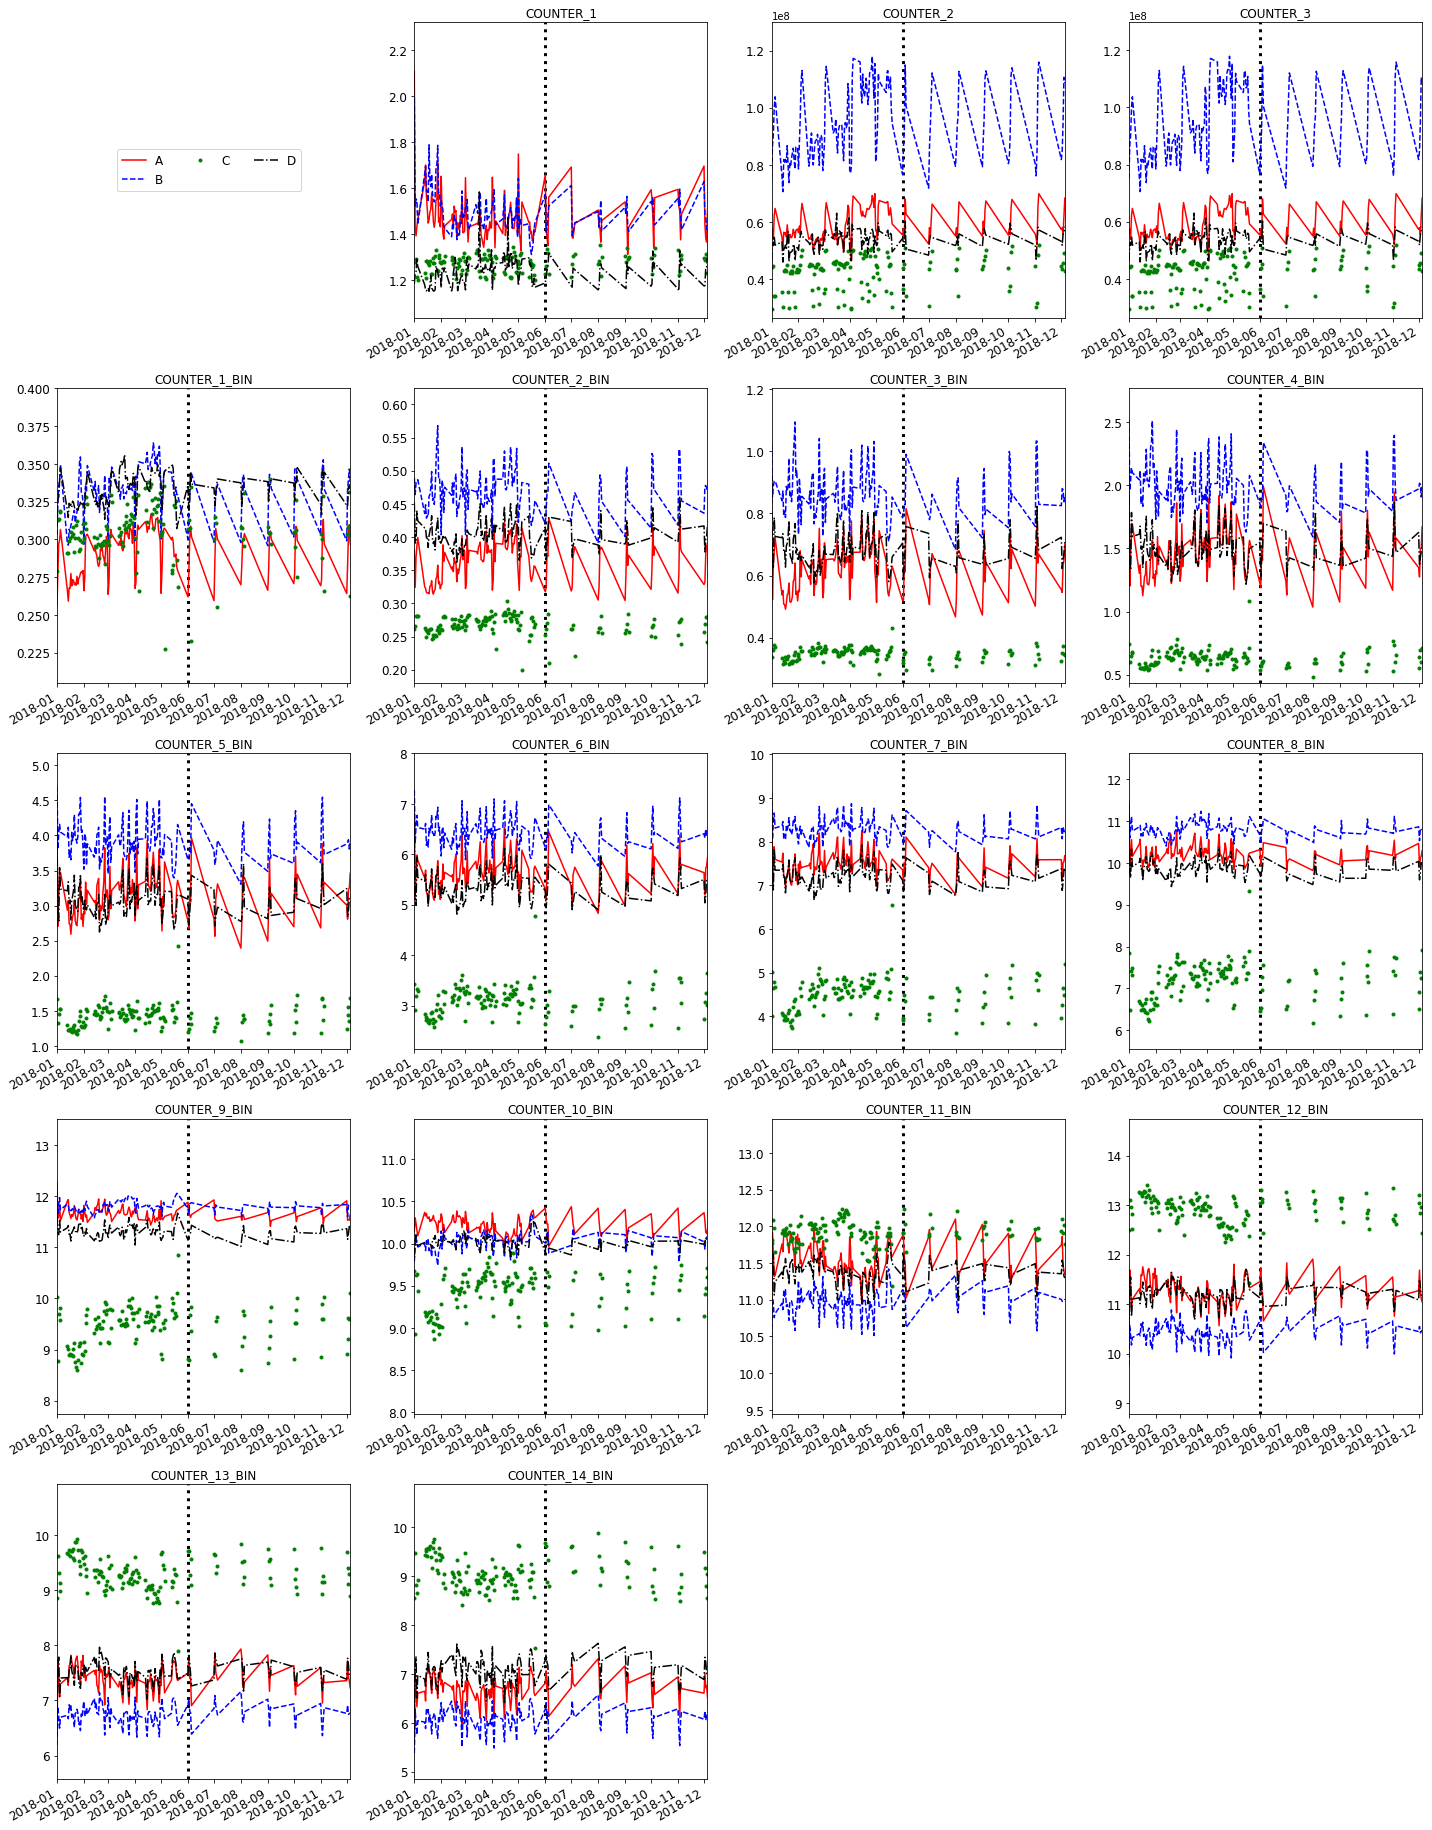

In [17]:
plt_all_dtime(b, "01-06-2018", styles=["r-","b--", "g.", "k-."])